In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm
from adjustText import adjust_text
import os
from statannotations.Annotator import Annotator

output_dir = '../../../LCMS/'


def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette):
    # Draw the boxplot with a semi-transparent fill (alpha=0.5) applied via boxprops.
    ax = sns.boxplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        palette=palette, 
        order=order, 
        width=0.5, 
       # capsize=0.1, 
        linewidth=1,

        showfliers=False
    )
    # Overlay the stripplot
    sp = sns.stripplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        dodge=False, 
        jitter=0.1, 
        alpha=1,  
        order=order, 
        color='black',
        #palette=palette,
        size=3
    )

    ax.set_ylim(0, np.max(d[y_val])*1.2)

    #plt.ylim(0, plt.ylim()[1])
    # Shift the stripplot points slightly to the left.
    shift = 0.4  # Adjust this value as needed
    for i, coll in enumerate(sp.collections):
        # if i == 0:
        #     shift = 0.4
        # elif i == 1:
        #     shift = 0.4
        # elif i == 2:
        #     shift = 0.4
            
        offsets = coll.get_offsets()
        # Subtract from the x-coordinate to move left
        offsets[:, 0] = offsets[:, 0] + shift
        coll.set_offsets(offsets)
    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order=order)
    annotator.configure(test='t-test_ind', text_format='full', loc='outside',
                        verbose=2, show_test_name=False, line_offset_to_group=1000,  # Increases space between the brackets and the plot
    text_offset=5)
    annotator.apply_and_annotate()

    plt.xticks(rotation=0)
    plt.xlabel('')

    # Adjust the boxes so that the face remains semi-transparent while the edge is opaque.
    # Try iterating over both ax.artists and ax.patches.
    for patch in ax.patches:
        # Get the current facecolor (an RGBA tuple)
        fc = patch.get_facecolor()
        # Set the facecolor to have your desired alpha (e.g., 0.5)
        patch.set_facecolor((fc[0], fc[1], fc[2], 0.5))
        # Set the edgecolor to the same RGB but fully opaque (alpha=1)
        #patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
        patch.set_linewidth(1)

    return ax


#plt.savefig('../../paper/main_plots/tmrm_choline_boxplot.png', dpi=300, bbox_inches='tight')


In [2]:
# Load data 

# Load the Excel file
excel_file = os.path.join(output_dir, '7689.SUB15127_MetabolomicsData_Targeted.xlsx')

# Load the sheet into a DataFrame
sheet_name = 'Targeted'  # Replace with the actual sheet name if different
data = pd.read_excel(excel_file, sheet_name=sheet_name)


In [3]:
# remove outliers as determined by Core (Y_A, E3_C and YC_F (SPL1, 11 and 24))
data = data[(data['Unnamed: 1']!='Y_A') & (data['Unnamed: 1']!='E3_C') & (data['Unnamed: 1']!='YC_F')]


In [4]:
# extract only experiment 2
experiment2 = data[data['Unnamed: 3']=='experiment_2']
experiment2 = data[data['Unnamed: 3']=='experiment_2']
# replace N/F with NaN
experiment2.replace('N/F', np.nan, inplace=True)
# add blank row to the end of the dataframe
experiment2 = pd.concat([experiment2.T, data.loc[2]], axis=1).T
# add grp column
experiment2['grp'] = ['B', 'B', 'BC', 'BC', 'Y', 'Y', 'Y', 'Y', 'YC', 'YC', 'YC', 'YC', 'blank']
# select choline species
sele = ['grp', 'Betaine','AcetylCholine', 'CDP', 'CDP-choline', 'Choline','GlycerylPhosphorylCholine', 'PhosphorylCholine']
experiment2_sele = experiment2[sele]
# drop any species that were not detected in one or more samples
#experiment2_sele.dropna(axis=1, inplace=True)
experiment2_sele.replace('N/F', 0, inplace=True)
experiment2_sele.fillna(0, inplace=True)

# subtract blank from remaining samples
out = []
for col in experiment2_sele.columns[1:]:
    out.append(experiment2_sele[col].values[:-1]-experiment2_sele[col].values[-1])

df = pd.DataFrame(np.vstack(out)).T
df.columns = experiment2_sele.columns[1:]
df['grp'] = experiment2_sele['grp'].values[:-1]

# for Choline and GlycerylPhosphorylCholine Blank values are orders of magnitude lower
df

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_11586/1658317428.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  experiment2.replace('N/F', np.nan, inplace=True)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_11586/1658317428.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment2.replace('N/F', np.nan, inplace=True)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_11586/1658317428.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly c

,Betaine,AcetylCholine,CDP,CDP-choline,Choline,GlycerylPhosphorylCholine,PhosphorylCholine,grp
0,0.0,485711.0,690768.0,0.0,2.356187e+09,267010706.0,2.771630e+05,B
1,0.0,761499.0,747302.0,0.0,2.123207e+09,261398168.0,1.174380e+05,B
2,0.0,586175.0,787015.0,103756793.0,2.748380e+09,266927614.0,4.378922e+07,BC
3,0.0,833157.0,847530.0,132916842.0,2.239380e+09,249848577.0,5.795410e+07,BC
4,20660232.0,1074329.0,816782.0,0.0,4.093128e+09,314901710.0,3.233981e+07,Y
5,17786490.0,389393.0,708315.0,0.0,3.223730e+09,294114266.0,2.285271e+07,Y
6,15485064.0,1634278.0,720334.0,0.0,3.495366e+09,331376943.0,2.090188e+07,Y
7,15641210.0,811097.0,753229.0,0.0,2.869227e+09,263000154.0,2.043855e+07,Y
8,22298990.0,3434133.0,814553.0,103586455.0,4.657031e+09,279674641.0,1.426550e+09,YC
9,19346963.0,728837.0,1029116.0,108050715.0,4.734404e+09,285928077.0,1.148395e+09,YC


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na o

BC vs. YC: t-test independent samples, P_val:3.919e-01 t=9.589e-01
B vs. BC: t-test independent samples, P_val:1.410e-01 t=-2.372e+00
Y vs. YC: t-test independent samples, P_val:9.220e-03 t=-3.776e+00
BC vs. YC: t-test independent samples, P_val:1.283e-01 t=-1.913e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


B vs. BC: t-test independent samples, P_val:4.597e-01 t=-9.081e-01
Y vs. YC: t-test independent samples, P_val:2.567e-03 t=-4.954e+00
BC vs. YC: t-test independent samples, P_val:1.860e-04 t=-1.328e+01


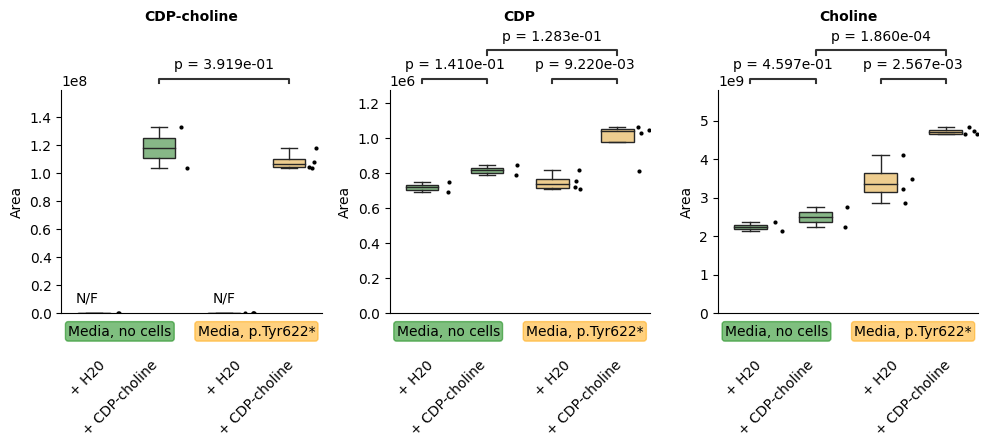

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=False)
axes = axes.flatten()  # flatten to iterate easily
names = ['CDP-choline', 'CDP', 'Choline']#, 'PhosphorylCholine', 'AcetylCholine']
colors = {'B': 'green', 'BC': 'green', 'Y': 'orange', 'YC': 'orange'}

# Loop through your names and plot on the corresponding axes
for i, name in enumerate(names):
    ax = axes[i]
    plt.sca(ax)
    # Assume plot_boxplot_by_treatment returns the axis you need.

    if name == 'CDP-choline':
        ax = plot_boxplot_by_treatment(df, 'grp', name, order=['B', 'BC', 'Y', 'YC'], 
                                   pairs=(['BC', 'YC'],), palette=colors)
        ax.text(2, 0.1, "N/F", ha='center', va='top', transform=ax.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10)
        ax.text(-0.1, 0.1, "N/F", ha='center', va='top', transform=ax.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10)
        
    else:
        ax = plot_boxplot_by_treatment(df, 'grp', name, order=['B', 'BC', 'Y', 'YC'], 
                                   pairs=(['B', 'BC'], ['Y', 'YC'], ['BC', 'YC']), palette=colors)
    ax.set_xticks([])

    # Add custom text labels
    ax.text(0.4, -0.05, "Media, no cells", ha='center', va='top', transform=ax.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="green", ec="green", alpha=0.5), fontsize=10)

    ax.text(2.5, -0.05, "Media, p.Tyr622*", ha='center', va='top', transform=ax.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=10)

    ax.text(2.5, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)
    ax.text(2, -0.2, "+ H20", ha='center', va='top', transform=ax.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax.text(0.4, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)
    ax.text(-0.1, -0.2, "+ H20", ha='center', va='top', transform=ax.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Area', fontsize=10)
    ax.set_title(f'{name}', pad=50, fontsize=10, fontweight='bold')
    ax.set_ylim(0, np.max(df[name]) * 1.2)

# Hide the extra subplot (8th axis) if it exists
if len(axes) > len(names):
    axes[-1].set_visible(False)

plt.tight_layout()
# Optionally save the figure:
# fig.savefig('../../paper/extended_plots/choline_media_lcms.png', dpi=300, bbox_inches='tight')
fig.savefig('../../../paper/extended_plots/choline_media_lcms.png', dpi=300, bbox_inches='tight', )

plt.show()


In [9]:
# Choline increase in media without cells after treatment
2.493880e+09/2.239697e+09

1.1134899051076999

In [10]:
# CDP increase in media without cells after treatment
817272.50/719035.00

1.1366240864491992

In [11]:
# Choline increase in media with cells after treatment 
4.715857e+09/3.420363e+09


1.3787592135688522

In [12]:
# CDP increase in media with cells after treatment 
988785.75/749665.00

1.3189701399958649

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na o

B vs. BC: t-test independent samples, P_val:1.410e-01 t=-2.372e+00
Y vs. YC: t-test independent samples, P_val:9.220e-03 t=-3.776e+00
BC vs. YC: t-test independent samples, P_val:1.283e-01 t=-1.913e+00
B vs. BC: t-test independent samples, P_val:4.597e-01 t=-9.081e-01
Y vs. YC: t-test independent samples, P_val:2.567e-03 t=-4.954e+00
BC vs. YC: t-test independent samples, P_val:1.860e-04 t=-1.328e+01


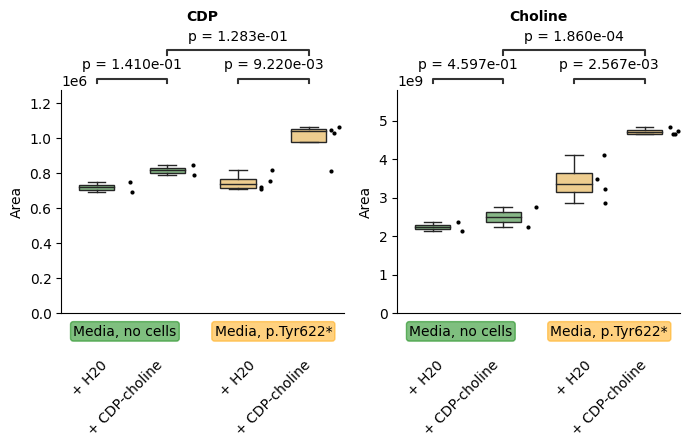

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5), sharey=False)
axes = [ax1, ax2]
names = ['CDP', 'Choline']
colors = {'B': 'green', 'BC': 'green', 'Y': 'orange', 'YC': 'orange'}

for i, name in enumerate(names):
    ax1 = axes[i]
    plt.sca(ax1)
    ax1 = plot_boxplot_by_treatment(df, 'grp', name, order=['B', 'BC', 'Y', 'YC'], pairs=(['B', 'BC'], ['Y', 'YC'], ['BC', 'YC']), palette=colors)
    ax1.set_xticks([])

    ax1.text(0.4, -0.05, "Media, no cells", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="green", ec="green", alpha=0.5), fontsize=10)

    ax1.text(2.5, -0.05, "Media, p.Tyr622*", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=10)

    ax1.text(2.5, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)
    ax1.text(2, -0.2, "+ H20", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax1.text(0.4, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)
    ax1.text(-0.1, -0.2, "+ H20", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylabel('Area', fontsize=10)
    ax1.set_title(f'{name}', pad=50, fontsize=10, fontweight='bold')
    ax1.set_ylim(0, np.max(df[name])*1.2)
#axes[0].set_ylabel('Area', fontsize=10)
plt.tight_layout()

fig.savefig('../../paper/extended_plots/choline_media_lcms.png', dpi=300, bbox_inches='tight', )


In [103]:
experiment1 = data[data['Unnamed: 3']=='experiment_1']
experiment1 = data[data['Unnamed: 3']=='experiment_1']

# replace N/F with NaN
experiment1.replace('N/F', np.nan, inplace=True)
experiment1 = pd.concat([experiment1.T, data.loc[2]], axis=1).T

experiment1['grp'] = [str(x).split('_')[0] for x in experiment1['Unnamed: 1']]


# select choline species
sele = ['grp', 'Betaine','AcetylCholine', 'CDP', 'CDP-choline', 'Choline','GlycerylPhosphorylCholine', 'PhosphorylCholine']
experiment1_sele = experiment1[sele]
# drop any species that were not detected in one or more samples
#experiment1_sele.dropna(axis=1, inplace=True)
experiment1_sele.replace('N/F', 0, inplace=True)
experiment1_sele.fillna(0, inplace=True)
# subtract blank from remaining samples
out = []
for col in experiment1_sele.columns[1:]:
    out.append(experiment1_sele[col].values[:-1]-experiment1_sele[col].values[-1])

df = pd.DataFrame(np.vstack(out)).T
df.columns = experiment1_sele.columns[1:]
df['grp'] = experiment1_sele['grp'].values[:-1]
df

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_52175/2516643595.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  experiment1.replace('N/F', np.nan, inplace=True)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_52175/2516643595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment1.replace('N/F', np.nan, inplace=True)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_52175/2516643595.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly c

,Betaine,AcetylCholine,CDP,CDP-choline,Choline,GlycerylPhosphorylCholine,PhosphorylCholine,grp
0,32675370.0,15354217.0,0.0,0.0,-451375.0,4684267.0,54176510.0,Y
1,43972874.0,33457242.0,0.0,0.0,522189.0,31080437.0,123005717.0,Y
2,46783286.0,23644734.0,0.0,0.0,1267248.0,22276180.0,85739762.0,Y
3,224463470.0,14464790.0,0.0,0.0,5770065.0,9761845.0,31253880.0,Y
4,40008357.0,38367745.0,0.0,0.0,4451072.0,45211456.0,146793262.0,Y
5,45345861.0,35030315.0,0.0,0.0,4243160.0,34174049.0,78549468.0,Y
6,60976749.0,38836591.0,0.0,0.0,5518605.0,42636959.0,119924937.0,Y
7,110727565.0,23098802.0,0.0,170221.0,72284488.0,9449188.0,106068545.0,Y
8,64150852.0,32172314.0,0.0,64157.0,70492944.0,6114670.0,52406475.0,E3
9,34334023.0,41427573.0,0.0,98584.0,9555371.0,22799539.0,193707865.0,E3


In [104]:
# sig decrease in CDP-choline in p.Tyr622* cells by fisher test
df['binary'] = df['CDP-choline']>0
temp = pd.crosstab(df['binary'], df['grp'])
table = temp[['E3', 'Y']]
table

grp,E3,Y
binary,,
False,1,7
True,9,1


In [105]:

import pandas as pd
import numpy as np
from scipy.stats import fisher_exact


# Two-sided Fisher's Exact Test
oddsratio, p_value = fisher_exact(table, alternative='two-sided')
p_value

0.002879473467708763

In [ ]:
###Not sure about below yet ..

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na o

Y vs. YC: t-test independent samples, P_val:4.554e-01 t=7.677e-01
E3 vs. Y: t-test independent samples, P_val:7.536e-02 t=1.902e+00
Y vs. YC: t-test independent samples, P_val:2.212e-03 t=-3.736e+00
E3 vs. Y: t-test independent samples, P_val:9.175e-02 t=1.794e+00
Y vs. YC: t-test independent samples, P_val:1.623e-01 t=-1.475e+00
E3 vs. Y: t-test independent samples, P_val:2.368e-01 t=1.229e+00
Y vs. YC: t-test independent samples, P_val:5.100e-03 t=-3.316e+00
E3 vs. Y: t-test independent samples, P_val:7.496e-01 t=-3.248e-01


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


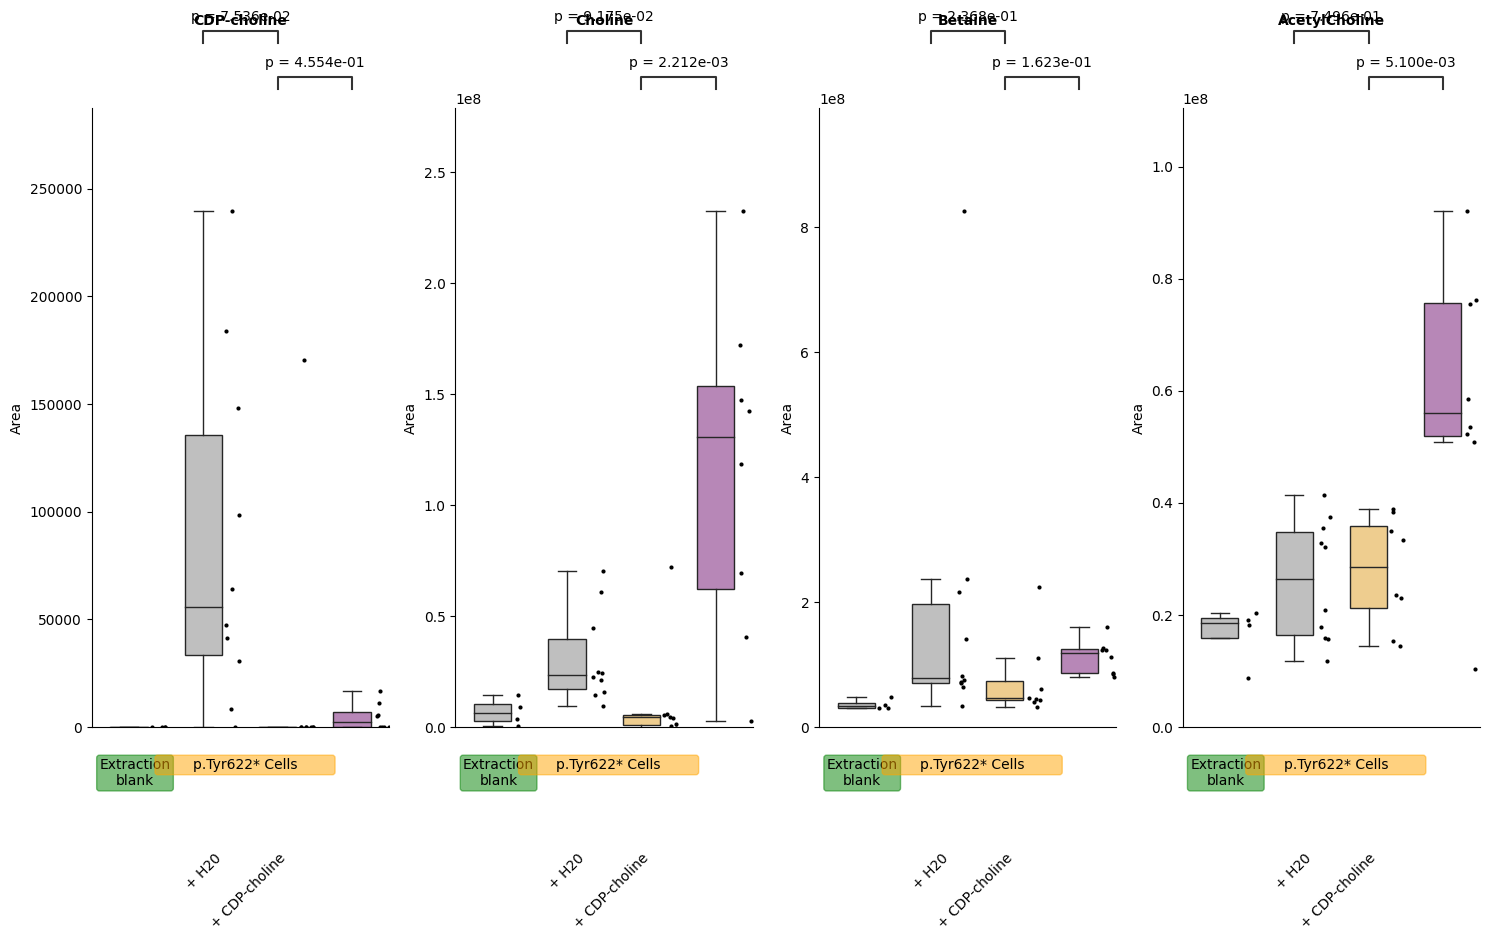

In [106]:
# Create a 2x4 grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 10), sharey=False)
axes = axes.flatten()  # flatten to iterate easily
names = ['CDP-choline', 'Choline', 'Betaine', 'AcetylCholine']#'GlycerylPhosphorylCholine', 'PhosphorylCholine']
colors = {'B': 'green', 'BC': 'green', 'Y': 'orange', 'YC': 'purple'}

colors = {'con':'grey', 'E3':'grey', 'Y': 'orange', 'YC': 'purple'}

for i, name in enumerate(names):
    ax1 = axes[i]
    plt.sca(ax1)
    ax1 = plot_boxplot_by_treatment(df, 'grp', name, order=['con', 'E3', 'Y', 'YC'], pairs=( ['Y', 'YC'], ['E3', 'Y']), palette=colors)
    ax1.set_xticks([])

    ax1.text(0.08, -0.05, "Extraction\nblank", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="green", ec="green", alpha=0.5), fontsize=10)

    ax1.text(1.56, -0.05, "        p.Tyr622* Cells        ", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=10)

    ax1.text(1.6, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax1.text(1, -0.2, "+ H20", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylabel('Area', fontsize=10)
    ax1.set_title(f'{name}', pad=60, fontsize=10, fontweight='bold')
    ax1.set_ylim(0, np.max(df[name])*1.2)
#axes[0].set_ylabel('Area', fontsize=10)
plt.tight_layout()

con vs. Y: t-test independent samples, P_val:7.091e-01 t=-3.839e-01
Y vs. YC: t-test independent samples, P_val:2.212e-03 t=-3.736e+00
con vs. YC: t-test independent samples, P_val:1.761e-02 t=-2.838e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


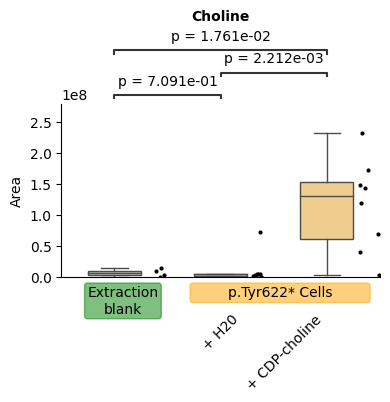

In [16]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 5), sharey=False)
axes = [ax1]
names = ['Choline']
colors = {'con':'grey','Y': 'orange', 'YC': 'orange'}

for i, name in enumerate(names):
    ax1 = axes[i]
    plt.sca(ax1)
    ax1 = plot_boxplot_by_treatment(df, 'grp', name, order=['con', 'Y', 'YC'], pairs=(['con', 'Y'], ['Y', 'YC'], ['con', 'YC']), palette=colors)
    ax1.set_xticks([])

    ax1.text(0.08, -0.05, "Extraction\nblank", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="green", ec="green", alpha=0.5), fontsize=10)

    ax1.text(1.56, -0.05, "        p.Tyr622* Cells        ", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=10)

    ax1.text(1.6, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax1.text(1, -0.2, "+ H20", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylabel('Area', fontsize=10)
    ax1.set_title(f'{name}', pad=60, fontsize=10, fontweight='bold')
    ax1.set_ylim(0, np.max(df[name])*1.2)
#axes[0].set_ylabel('Area', fontsize=10)
plt.tight_layout()

fig.savefig('../../paper/extended_plots/choline_in_cells_lcms.png', dpi=300, bbox_inches='tight', )


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5), sharey=False)
axes = [ax1, ax2]
names = ['CDP', 'Choline']
colors = {'B': 'green', 'BC': 'green', 'Y': 'orange', 'YC': 'orange'}

for i, name in enumerate(names):
    ax1 = axes[i]
    plt.sca(ax1)
    ax1 = plot_boxplot_by_treatment(df, 'grp', name, order=['B', 'BC', 'Y', 'YC'], pairs=(['B', 'BC'], ['Y', 'YC'], ['BC', 'YC']), palette=colors)
    ax1.set_xticks([])

    ax1.text(0.4, -0.05, "Media, no cells", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="green", ec="green", alpha=0.5), fontsize=10)

    ax1.text(2.5, -0.05, "Media, p.Tyr622*", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=10)

    ax1.text(2.5, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)
    ax1.text(2, -0.2, "+ H20", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax1.text(0.4, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)
    ax1.text(-0.1, -0.2, "+ H20", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylabel('Area', fontsize=10)
    ax1.set_title(f'{name}', pad=50, fontsize=10, fontweight='bold')
    ax1.set_ylim(0, np.max(df[name])*1.2)
#axes[0].set_ylabel('Area', fontsize=10)
plt.tight_layout()

fig.savefig('../../paper/extended_plots/choline_media_lcms.png', dpi=300, bbox_inches='tight', )


In [29]:
temp = experiment2[['grp', 'Unnamed: 1', 'Unnamed: 2', 'CDP-choline']].iloc[:-1]
temp.fillna(0, inplace=True)
temp

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_52175/604482657.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp.fillna(0, inplace=True)


,grp,Unnamed: 1,Unnamed: 2,CDP-choline
38,B,B1 media_no_cells,+H20,0.0
39,B,B2 media_no_cells,+H20,0.0
40,BC,BC1 media_no_cells,+C,103756793.0
41,BC,BC2 media_no_cells,+C,132916842.0
42,Y,Y1 media,+H20,0.0
43,Y,Y2 media,+H20,0.0
44,Y,Y3 media,+H20,0.0
45,Y,Y4 media,+H20,0.0
46,YC,YC1 media,+C,103586455.0
47,YC,YC2 media,+C,108050715.0


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5), sharey=False)
axes = [ax1, ax2]
names = ['CDP', 'Choline']
colors = {'B': 'green', 'BC': 'green', 'Y': 'orange', 'YC': 'orange'}

for i, name in enumerate(names):
    ax1 = axes[i]
    plt.sca(ax1)
    ax1 = plot_boxplot_by_treatment(df, 'grp', name, order=['B', 'BC', 'Y', 'YC'], pairs=(['B', 'BC'], ['Y', 'YC'], ['BC', 'YC']), palette=colors)
    ax1.set_xticks([])

    ax1.text(0.4, -0.05, "Media, no cells", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="green", ec="green", alpha=0.5), fontsize=10)

    ax1.text(2.5, -0.05, "Media, p.Tyr622*", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=10)

    ax1.text(2.5, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)
    ax1.text(2, -0.2, "+ H20", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax1.text(0.4, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)
    ax1.text(-0.1, -0.2, "+ H20", ha='center', va='top', transform=ax1.get_xaxis_transform(),
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylabel('Area', fontsize=10)
    ax1.set_title(f'{name}', pad=50, fontsize=10, fontweight='bold')
    ax1.set_ylim(0, np.max(df[name])*1.2)
#axes[0].set_ylabel('Area', fontsize=10)
plt.tight_layout()

fig.savefig('../../paper/extended_plots/choline_media_lcms.png', dpi=300, bbox_inches='tight', )


In [26]:
experiment2[['grp', 'Unnamed: 1', 'Unnamed: 2', 'CDP-choline']]

,grp,Unnamed: 1,Unnamed: 2,CDP-choline
38,B,B1 media_no_cells,+H20,NaN
39,B,B2 media_no_cells,+H20,NaN
40,BC,BC1 media_no_cells,+C,103756793.0
41,BC,BC2 media_no_cells,+C,132916842.0
42,Y,Y1 media,+H20,NaN
43,Y,Y2 media,+H20,NaN
44,Y,Y3 media,+H20,NaN
45,Y,Y4 media,+H20,NaN
46,YC,YC1 media,+C,103586455.0
47,YC,YC2 media,+C,108050715.0
